In [1]:
# import vtkplotter
import os; os.chdir("/home/ubuntu/coma/")
from cardiac_mesh import CardiacMesh
from VTK.VTKMesh import VTKObject as Mesh
import vtk
from itkwidgets import view
import itk
import numpy as np
import helpers
from copy import deepcopy

In [2]:
# subparts_ids = CardiacMesh.subparts_ids
# 
# lv_m = Mesh(filename="data/vtk_meshes/1000336/output.001.vtk")
# lv_m_endo = lv_m.extractSubpart(subparts_ids["LV_endo"])
# lv_m_epi = lv_m.extractSubpart(subparts_ids["LV_epi"])
# 
# lv_m_endo = vtkplotter.mesh.Mesh([lv_m_endo.points, lv_m_endo.triangles])
# lv_m_epi = vtkplotter.mesh.Mesh([lv_m_epi.points, lv_m_epi.triangles])
# 
# pp = vtkplotter.mesh.merge([lv_m_endo, lv_m_epi])
# # vtkplotter.mesh.Mesh()

In [3]:
coma_dir = "/MULTIX/DATA/INPUT/disk_2/coma/Cardio"
output_dir = "{}/output".format(coma_dir)

file_name = "{}/meshes/vtk_meshes/1000336/output.001.vtk".format(coma_dir)
# itk.meshread(file_name)

reader = vtk.vtkPolyDataReader()
reader.SetFileName(file_name)
reader.Update()
mesh = reader.GetOutput()
viewer = view(geometries=mesh)


In [4]:
# 1. Select model
##   a. Read all the data for the chamber (do once)
##   b. Read the latent space representation for each subject.

# 2. Calculate E(mean shape). Is it close to mean(z) or median(z)?
# 3. Display.
# 4. Create widget for each of the latent variables (start with nz = 4). Need to convert from N(0,1) to real range.
# 5. Calculate shape as D(E(mean shape) + z)
# 6. Display
# 7. Interpret

In [5]:
# Select model
import os
import ipywidgets as widgets
import pandas as pd

In [6]:
run_ids = [
    "2020-04-24_11_03_10_723719",
    "2020-04-26_07_36_30_873605",
    "2020-04-24_13_19_26_631106",
    "2020-04-19_10_01_33_510833",
    "2020-04-30_17_29_19_775837",
    "2020-04-19_03_11_19_339030"     
]

run_params_df = pd.read_csv("{}/run_parameters.csv".format(output_dir))

In [7]:
# yaml_files = [x for x in os.listdir(coma_yml_dir) if x.endswith(".yaml") and x.startswith("config")] 

w_yaml = widgets.Select(
    options=run_ids,
    description='Run ID',
    disabled=False,
    value=run_ids[1]
)

display(w_yaml)

U2VsZWN0KGRlc2NyaXB0aW9uPXUnUnVuIElEJywgaW5kZXg9MSwgb3B0aW9ucz0oJzIwMjAtMDQtMjRfMTFfMDNfMTBfNzIzNzE5JywgJzIwMjAtMDQtMjZfMDdfMzZfMzBfODczNjA1JywgJzLigKY=


In [60]:
run_info = helpers.Run(w_yaml.value, output_dir)
z_df = pd.read_csv(run_info.latent_space)

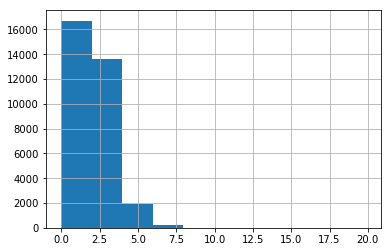

In [111]:
z_df.hist()

In [9]:
from main import generate_model
params = deepcopy(run_info.params) # I need to deepcopy because I delete the 'seed' key
del params['seed']

In [124]:
params['F']

[16, 16, 16, 32]

In [10]:
model = generate_model(params, add_hash=False)
model.dir_name = os.path.basename(run_info.checkpoints)

Loading data .. 
Vertices normalized
Generating Transform Matrices ..


`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Computing Graph Laplacians ..
NN architecture


In [11]:
from scipy.spatial import procrustes as procrustes

all_meshes = np.load(params['data_file'], allow_pickle=True)
all_ids = [x.strip() for x in open(params['ids_file'])]
# Preprocess meshes (procrustes-aligning + centering + scaling)
meshes_aligned = np.array([ 
    procrustes(
        all_meshes[i], 
        model.reference_mesh.points)[0] for i in range(len(all_meshes)
    )
])

# meshes_aligned = (meshes_aligned - model.mean) / model.std

In [90]:
z_median = z_df.median(axis=0)[1:]


for j in range(len(z_median)):
  for i in range(-1, 2):
    # z = all_meshes[10]
    dz = i * np.eye(1,len(z_median),j)[0] * z_df.std(axis=0)[1:]
    reconstructed_mesh = model.decode(np.array([z_median + dz]))
    np.save("/home/ubuntu/tmp/tmp_z{}_plus{}sd.npy".format(str(j), str(i)), model.mean + model.std * reconstructed_mesh)

INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422

In [105]:
z_df.mean(axis=0)[1:]

z0    2.164149
z1    1.983794
z2    2.423693
z3    1.842730
z4    1.805067
z5    1.971674
z6    1.859372
z7    1.987806
dtype: float64

In [119]:
z_mean_shape = model.encode(np.array([np.random.normal(0,0,model.mean.shape)], dtype=np.float64))
z_mean_shape_2 = model.encode(model.decode(z_mean_shape))
z_mean_shape_2

INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000
INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000


array([[0.99717265, 1.0840019 , 1.3560876 , 0.9769249 , 0.9583    ,
        1.0134382 , 1.0725229 , 1.0263215 ]], dtype=float32)

In [122]:
run_info.params.F

AttributeError: 'dict' object has no attribute 'F'

In [113]:
np.save("/home/ubuntu/tmp/tmp.vtk", model.decode(z_mean_shape))

INFO:tensorflow:Restoring parameters from /MULTIX/DATA/INPUT/disk_2/coma/Cardio/output/checkpoints/LV__ds_4422__nz_8__reg_0.0001__lr_0.01__2020-04-26_07_36_30_873605/model-50000


In [39]:
from vtk.util.numpy_support import numpy_to_vtk, numpy_to_vtkIdTypeArray
def createPolyData(verts, tris):
    """Create and return a vtkPolyData.
    
    verts is a (N, 3) numpy array of float vertices

    tris is a (N, 1) numpy array of int64 representing the triangles
    (cells) we create from the verts above.  The array contains 
    groups of 4 integers of the form: 3 A B C
    Where 3 is the number of points in the cell and A B C are indexes
    into the verts array.
    """
    
    # save, we share memory with the numpy arrays
    # so they can't get deleted
    #self.verts = verts        
    # self.tris = tris
    
    poly = vtk.vtkPolyData()
    
    points = vtk.vtkPoints()
    points.SetData(numpy_to_vtk(verts))        
    poly.SetPoints(points)
    
    cells = vtk.vtkCellArray()
    cells.SetCells(len(tris), numpy_to_vtkIdTypeArray(tris))        
    #poly.SetCells(cells)
    poly.SetPolys(cells)
    
    return poly

In [40]:
dd = createPolyData(model.mean, np.array(model.reference_mesh.triangles))

In [41]:
vtk_filename = "/home/ubuntu/tmp/tmp.vtk"
vpw = vtk.vtkPolyDataWriter()
vpw.SetFileName(vtk_filename)
vpw.SetInputData(dd)

In [16]:
# kk = Mesh(vtk_filename)